# Analisis de Datos Faltantes sobre un Dataset de Boyas Oceanicas

In [1]:
# Librerias
import janitor
import matplotlib.pyplot as plt
import missingno
import numpy as np
import pandas as pd
import pyreadr
import seaborn as sns
#import session_info
import upsetplot

In [2]:
# linea para correr el notebook utils
%run utils.ipynb

## Cargar el conjunto de Datos desde una Web

In [3]:
# Guardar la url en una variable
datos_url = 'https://github.com/njtierney/naniar/raw/master/data/'

# Almacenar los nombres de los archivos a descargar en una lista
datasets_names = ('oceanbuoys', 'pedestrian', 'riskfactors')

# Almacenar el tipo de extension en una variable
extension = '.rda'

# diccionario que almacena los archivos descargados
datasets_dfs = {} 

for dataset_name in datasets_names:

    dataset_file = f'{ dataset_name }{ extension }' # almacena el nombre de cada archivo con su respectiva extension
    dataset_output_file = f'./data/{ dataset_file }' # ruta y nombre donde se guarda los archivos
    dataset_url = f'{ datos_url }{ dataset_file }' # url de cada archivo a descargar

    !wget -q -O { dataset_output_file } { dataset_url } # linea que descarga los archivos

    # almacenar en el diccionario los archivos descargados
    datasets_dfs[f'{ dataset_name }_df'] = pyreadr.read_r(dataset_output_file).get(dataset_name)

# accede a las llaves del diccionario para verificar que los archivos se hayan cargado
datasets_dfs.keys()

dict_keys(['oceanbuoys_df', 'pedestrian_df', 'riskfactors_df'])

### Incluir el conjunto de datos en nuestro ambiente local

In [4]:
locals().update(**datasets_dfs)
# elimina el diccionario para dejar solamente los dataframes
del datasets_dfs

In [5]:
# carga del dataframe
oceanbuoys_df.shape

(736, 8)

## Configuracion de las Graficas

In [6]:
%matplotlib inline

# tamaño de los graficos
sns.set(
    rc={
        'figure.figsize':(8, 8)
    }
)

# estilo de los graficos
sns.set_style('whitegrid')

## EDA de los datos

In [7]:
oceanbuoys_df

,year,latitude,longitude,sea_temp_c,air_temp_c,humidity,wind_ew,wind_ns
0,1997.0,0.0,-110.0,27.590000,27.150000,79.599998,-6.4,5.4
1,1997.0,0.0,-110.0,27.549999,27.020000,75.800003,-5.3,5.3
2,1997.0,0.0,-110.0,27.570000,27.000000,76.500000,-5.1,4.5
3,1997.0,0.0,-110.0,27.620001,26.930000,76.199997,-4.9,2.5
4,1997.0,0.0,-110.0,27.650000,26.840000,76.400002,-3.5,4.1
...,...,...,...,...,...,...,...,...
731,1993.0,-2.0,-110.0,24.780001,24.620001,90.800003,-4.4,1.7
732,1993.0,-2.0,-110.0,24.879999,24.500000,91.099998,-3.0,0.2
733,1993.0,-2.0,-110.0,25.120001,24.889999,89.699997,-4.0,1.1
734,1993.0,-2.0,-110.0,25.160000,24.930000,89.500000,-4.3,2.5


In [8]:
# Tipos de datos
oceanbuoys_df.dtypes

year          float64
latitude      float64
longitude     float64
sea_temp_c    float64
air_temp_c    float64
humidity      float64
wind_ew       float64
wind_ns       float64
dtype: object

Todas las variables son de tipo numerica flotante.

In [9]:
# variables que contienen valores nulos
(
    oceanbuoys_df
    .isna()
    .any()
)

year          False
latitude      False
longitude     False
sea_temp_c     True
air_temp_c     True
humidity       True
wind_ew       False
wind_ns       False
dtype: bool

Los valores nulos se concentran en las variables sea_temp_c, air_temp_c y humidity.

In [10]:
# Cantidad de valores nulos por variable
(
    oceanbuoys_df
    .isnull()
    .sum()
)

year           0
latitude       0
longitude      0
sea_temp_c     3
air_temp_c    81
humidity      93
wind_ew        0
wind_ns        0
dtype: int64

La mayor cantidad de valores nulos se concentran en air_temp_c y Humidity. Puede que haya alguna relacion entre estas variables.

In [11]:
# numero total de valores nulos
(
    oceanbuoys_df
    .isnull()
    .sum()
    .sum()
)

177

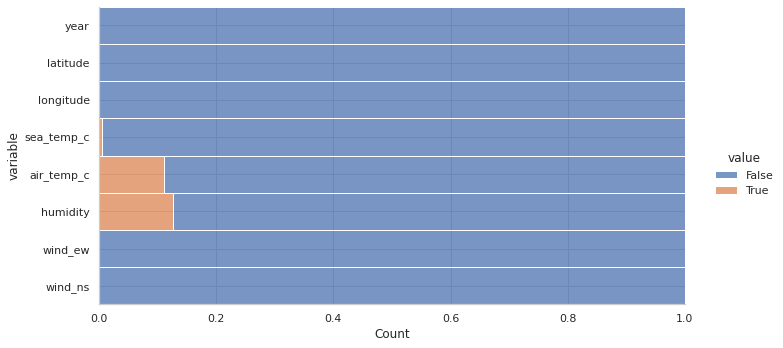

In [12]:
# Visualizacion de la proporcion de valores nulos por cada variable
(
    oceanbuoys_df
    .isnull()
    .melt()
    .pipe(
        lambda df:(
            sns.displot(
                data=df,
                y='variable',
                hue='value',
                multiple='fill',
                aspect=2
            )
        )
    )
)
plt.show()

In [13]:
# Numero de observaciones perdidas si se eliminan los valores faltantes
proof_oceanbuoys_df = (
    oceanbuoys_df
    .dropna()
)
proof_oceanbuoys_df.shape

(565, 8)

In [14]:
# numero de observaciones en el DF
oceanbuoys_df.shape

(736, 8)

In [15]:
# numero de observaciones eliminadas
736 - 565

171

In [16]:
# porcentaje que representa el numero de observaciones eliminadas
pct_of = 100 - (565/736)*100
pct_of

23.233695652173907

El dataframe contiene 736 observaciones. Si se eliminan los registros con valores faltantes quedan un total de 565 observaciones, es decir, se sacrifican mas de 171 observaciones que corresponden al 23% del total en el dataframe. Esto indica que no es recomendable utilizar el Metodo de eliminacion por lista para el tratamiento de valores faltantes ya que se pierde mucha informacion. 

### Resumen Estadistico de las variables

In [17]:
oceanbuoys_df.describe()

,year,latitude,longitude,sea_temp_c,air_temp_c,humidity,wind_ew,wind_ns
count,736.00000,736.000000,736.0000,733.000000,655.000000,643.000000,736.000000,736.000000
mean,1995.00000,-1.375000,-102.5000,25.864952,25.029252,84.434992,-3.715897,2.635734
std,2.00136,1.654719,7.5051,2.448436,2.000025,4.589332,1.958802,2.109857
min,1993.00000,-5.000000,-110.0000,21.600000,21.420000,71.599998,-8.100000,-6.200000
25%,1993.00000,-2.000000,-110.0000,23.500000,23.260000,81.300003,-5.100000,1.500000
50%,1995.00000,-1.000000,-102.5000,26.549999,24.520000,85.199997,-3.900000,2.900000
75%,1997.00000,0.000000,-95.0000,28.209999,27.080000,88.099998,-2.600000,4.100000
max,1997.00000,0.000000,-95.0000,30.170000,28.500000,94.800003,4.300000,7.300000


## Analisis Basico de Valores Faltantes sobre el DF

### Calculo del Porcentaje de valores faltantes

In [18]:
# cantidad de datos
total = 736*8
total

5888

In [19]:
# cantidad de valores completos
v_complet = oceanbuoys_df.missing.number_complete()
v_complet

5711

In [20]:
# cantidad de valores faltantes
v_mising = oceanbuoys_df.missing.number_missing()
v_mising

177

In [21]:
# Porcentaje de valores faltantes en el DF
pct_v = (v_mising/v_complet)*100
pct_v

3.09928208720014

Alrededor del 3% de los datos corresponden a valores faltantes. Aunque no representa un numero amplio, vamos a aplicar todo el analisis requerido.

### Estadistica de las variables segun los datos faltantes 

In [22]:
# estadistica de cada variable segun sus valores faltantes
oceanbuoys_df.missing.missing_variable_summary()

,variable,n_missing,n_cases,pct_missing
0,year,0,736,0.000000
1,latitude,0,736,0.000000
2,longitude,0,736,0.000000
3,sea_temp_c,3,736,0.407609
4,air_temp_c,81,736,11.005435
5,humidity,93,736,12.635870
6,wind_ew,0,736,0.000000
7,wind_ns,0,736,0.000000


En el resumen vemos que tanto air_temp_c como humidity son las variables con mayor cantidad de valores faltantes teniendo un 11% la primera y un 12.6% la segunda variable.

### Estadistica de valores faltantes segun el numero de variables

In [23]:
# estadistica de valores faltantes en funcion de las variables presentados en una Tabla
oceanbuoys_df.missing.missing_variable_table()

,n_missing_in_variable,n_variables,pct_variables
0,0,5,62.5
1,3,1,12.5
2,81,1,12.5
3,93,1,12.5


La tabla indica que hay 5 variables que no tienen valores faltantes, 1 con solo 3 missing, 1 con 81 missing y 1 con 93 missing para un total de 8 variables.

### Estadistica de valores faltantes para cada registro

In [24]:
# cantidad de valores faltantes para cada registro
oceanbuoys_df.missing.missing_case_summary()

,case,n_missing,pct_missing
0,0,0,0.0
1,1,0,0.0
2,2,0,0.0
3,3,0,0.0
4,4,0,0.0
...,...,...,...
731,731,0,0.0
732,732,0,0.0
733,733,0,0.0
734,734,0,0.0


### Estadistica tabulada de Registros con su correspondiente cantidad de valores faltantes

In [25]:
# registros con su correpondiente cantidad de valores faltantes
oceanbuoys_df.missing.missing_case_table()

,n_missing_in_case,n_cases,pct_case
0,0,565,76.766304
1,1,167,22.690217
2,2,2,0.271739
3,3,2,0.271739


la tabla indica que hay 565 registros que no poseen missing, 167 con solo 1 missing, 2 con 2 missing y 2 con solo 3 missing.

### Estadisticas de valores faltantes por intervalos de registros para una variable

In [26]:
# estadistica de valores faltantes para intervalos de 10 registros de la variable humidity
oceanbuoys_df.missing.missing_variable_span(variable='humidity',span_every=50)

,span_counter,n_missing,n_complete,pct_missing,pct_complete
0,0,0,50,0.0,100.0
1,1,0,50,0.0,100.0
2,2,0,50,0.0,100.0
3,3,0,50,0.0,100.0
4,4,0,50,0.0,100.0
5,5,0,50,0.0,100.0
6,6,0,50,0.0,100.0
7,7,0,50,0.0,100.0
8,8,0,50,0.0,100.0
9,9,41,9,82.0,18.0


La tabla anterior indica que el 82% de los datos de la variable humidity en el intervalo de 450 a 500 son valores faltantes. Mientras que todos los datos del intervalo que va de 500 a 550 son valores faltantes. De esta manera podemos apreciar los intervalos donde se concentran los missing.

### Estadistica de intervalos consecutivos con valores faltantes y completos para una variable

In [27]:
# estadistica de intervalos consecutivos con valores faltantes y 
# completos para la variable humidity
oceanbuoys_df.missing.missing_variable_run(variable='humidity')

,run_length,is_na
0,459,complete
1,93,missing
2,184,complete


La tabla indica que los primeros 459 registros de la variable humidity estan completos, los siguientes 93 registros possen missing y los restantes estan completos. Esto quiere decir que los missing de la variable estan concentrados en una zona particular lo que indica que no son missin aleatorios.

## Visualizacion de Valores Faltantes

### Visualizacion mediante un grafico de Paleta

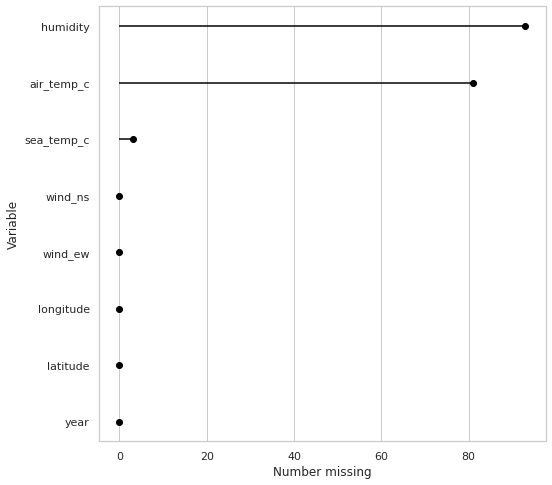

In [28]:
oceanbuoys_df.missing.missing_variable_plot()

La grafica ratifica que la variable con mayor numero de valores faltantes es humidity seguido de la variable air_temp_c

### Histograma de observaciones con datos faltantes

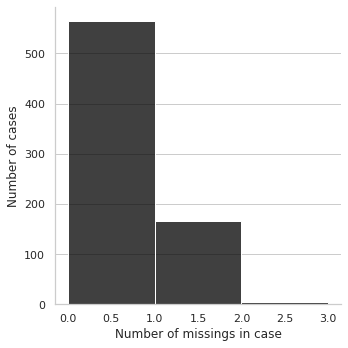

In [29]:
oceanbuoys_df.missing.missing_case_plot()

La grafica indica que hay mas de 500 observaciones con 1 solo missing y mas de 150 observaciones con 2 missing.

### Visualizacion de valores faltantes en una variable por rangos consecutivos

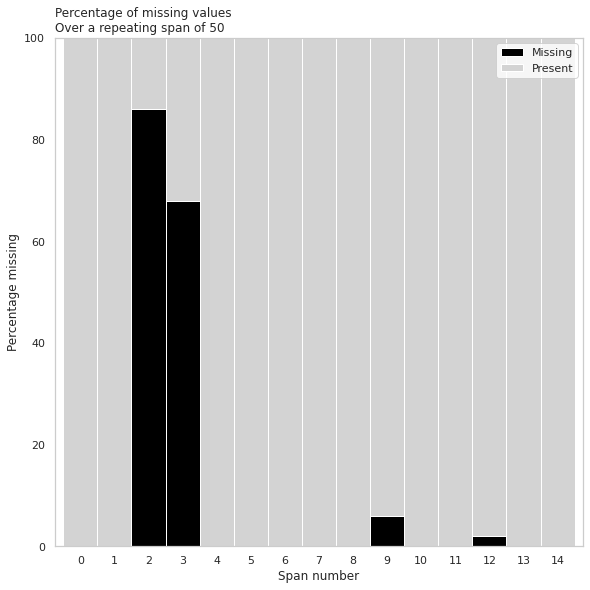

In [30]:
# visualizacion de valores faltantes para la variable air_temp_c en rangos de 50
(
    oceanbuoys_df
    .missing
    .missing_variable_span_plot(
        variable='air_temp_c', # variable a analizar
        span_every=50, # rango
        rot=0 # rotacion de las etiquetas
    )
)

Podemos concluir que mas del 80% de los datos del rango que va de 100 a 149 son datos faltantes. Tambien mas del 60% de los datos del rango que va de 150 a 199 son valores faltantes. Esto indica que para la variable air_temp_c los valores faltantes no son aleatorio sino que sigue cierto patron.

### Visualizacion de valores faltantes en todas las variables

<AxesSubplot:>

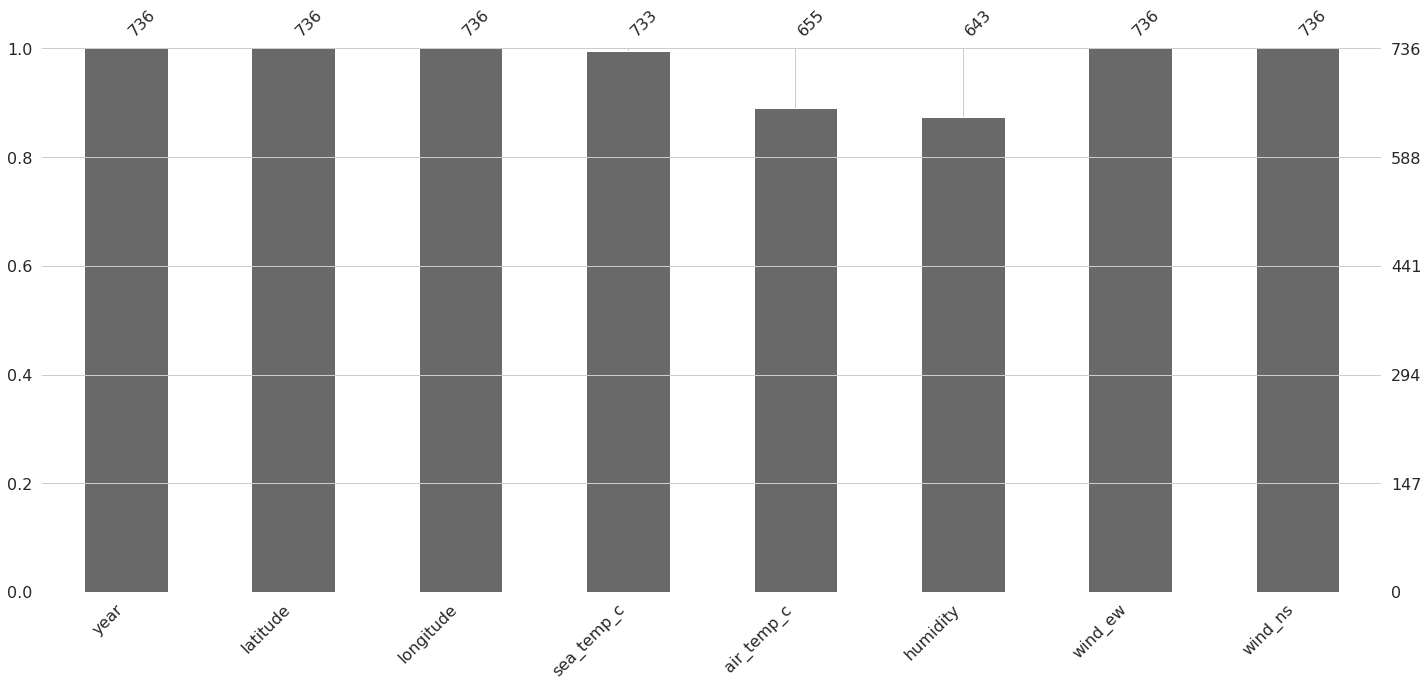

In [31]:
missingno.bar(df=oceanbuoys_df) # missigno es una funcion de pandas

Los espacios en blanco representan los valores faltantes. Claramente vemos que la moyr parte de missing se encuentran en las variables humidity y air_temp_c

### Visualizacion de valores faltantes en todas las variables mediante una matriz

<AxesSubplot:>

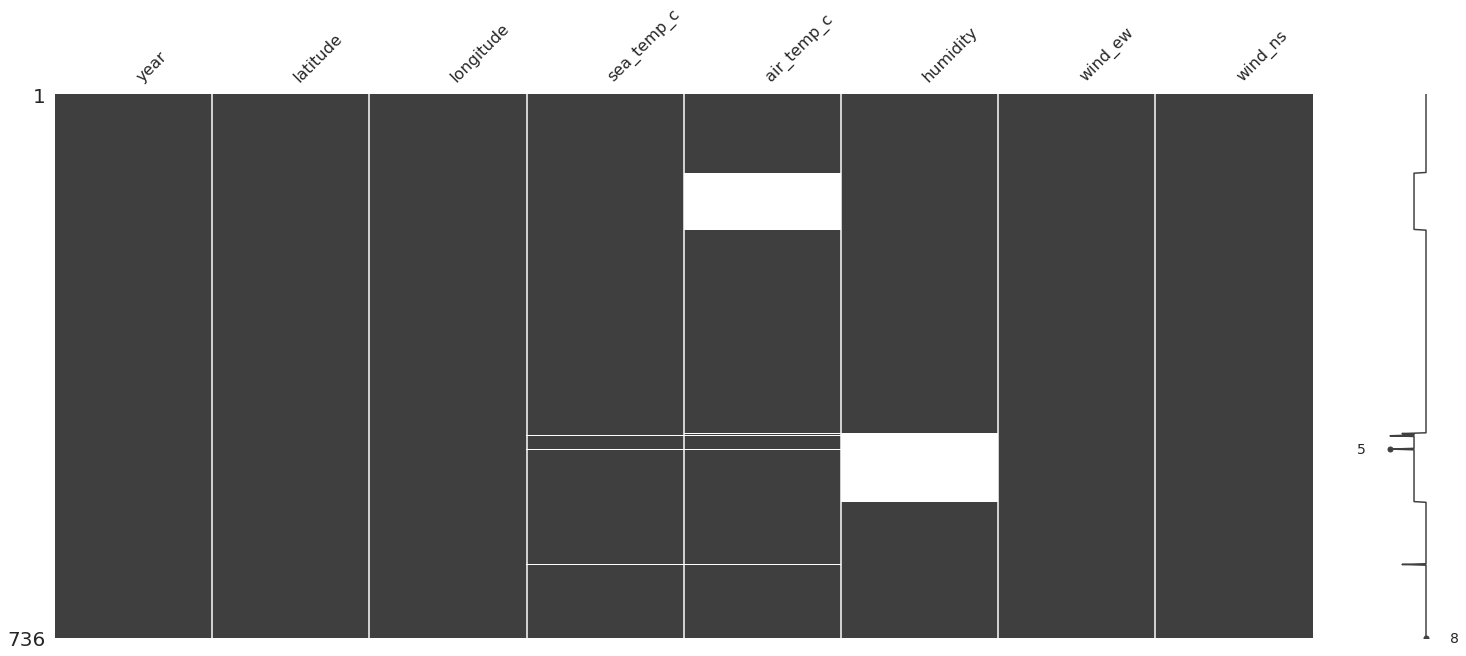

In [32]:
missingno.matrix(df=oceanbuoys_df)

Al inicio del analisis teniamos la hipotesis de que podria ver alguna relacion entre los valores faltantes de las variables humidity y air_temp_c. Al ver a detalle la grafica encontramos que no tienen relacion alguna. En cambio, donde vemos que existe una relacion es entre los missing de air_temp_c y sea_temp_c ya que cuando falta uno de ellos, falta en la otra variable.

### Visualizacion de apariciones conjuntas entre las variables mediantes un Upsetplot

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

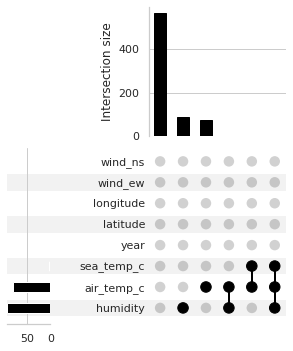

In [33]:
(
    oceanbuoys_df
    .missing
    .missing_upsetplot(
        variables=None, # None indica para todas las variables
        element_size = 30 # size del upsetplot
    )
)

El upsetplot indica que humidity alcanza casi las 100 observaciones con missing cuando las demas variables no poseen missing. Lo mismo ocurre para air_temp_c que alcanza las 80 observaciones con missing. Esto indica que no hay relacion entre los missing de ambas variables

## Determinacion del Tipo de Valores Faltantes

### Es de tipo MCAR?

<AxesSubplot:>

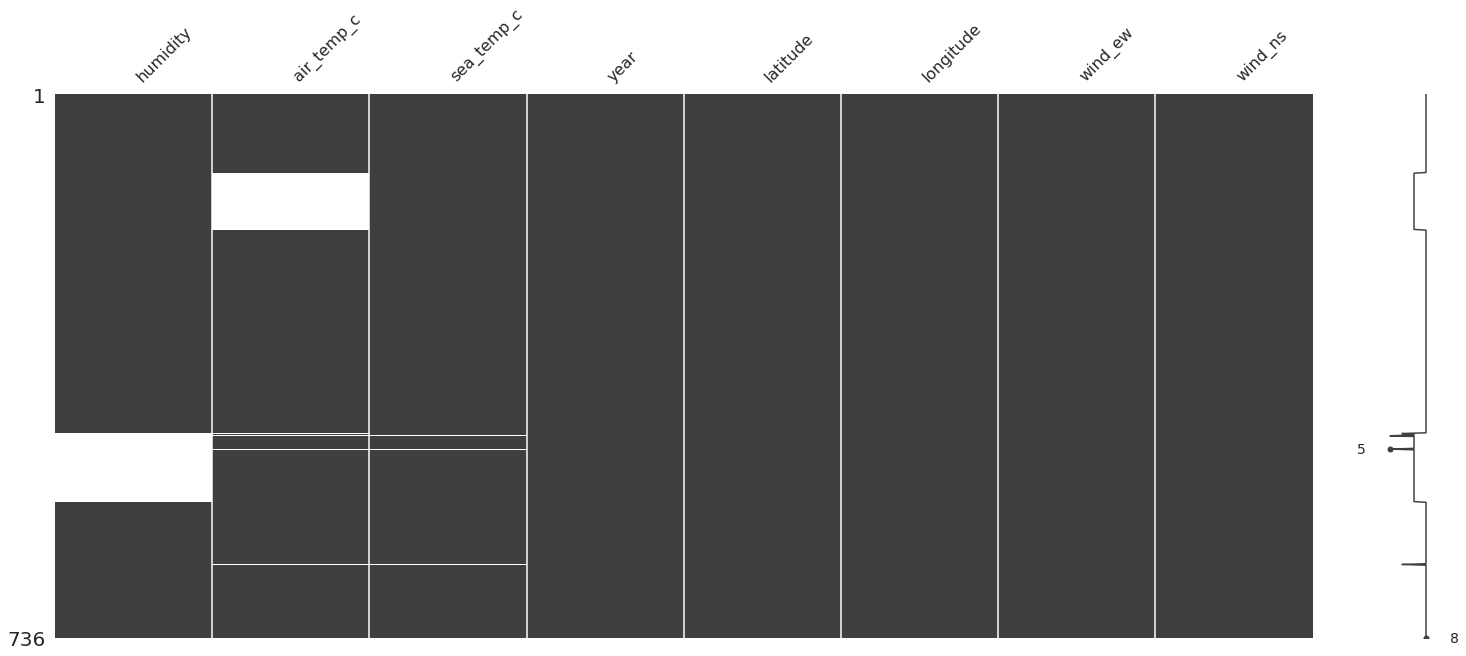

In [34]:
# ordena las variables segun el numero de missing de mayor a menor
(
    oceanbuoys_df # df
    .missing.sort_variables_by_missingness() # ordena las variables de mayor a menor cantidad de missing
    .pipe(missingno.matrix) # muestra el resultado como una matriz
)

Para este caso, vemos que las variables siguen un patron como en el caso de air_temp_c y sea_temp_c. Y ademas vemos que se encuentran agrupadas como es el caso de humidity y air_temp_c aunque no haya relacion entre ambas. Esto implica que los missing no estan localizados completamente al azar por lo que no son de tipo MCAR

### Es de tipo MAR?

<AxesSubplot:>

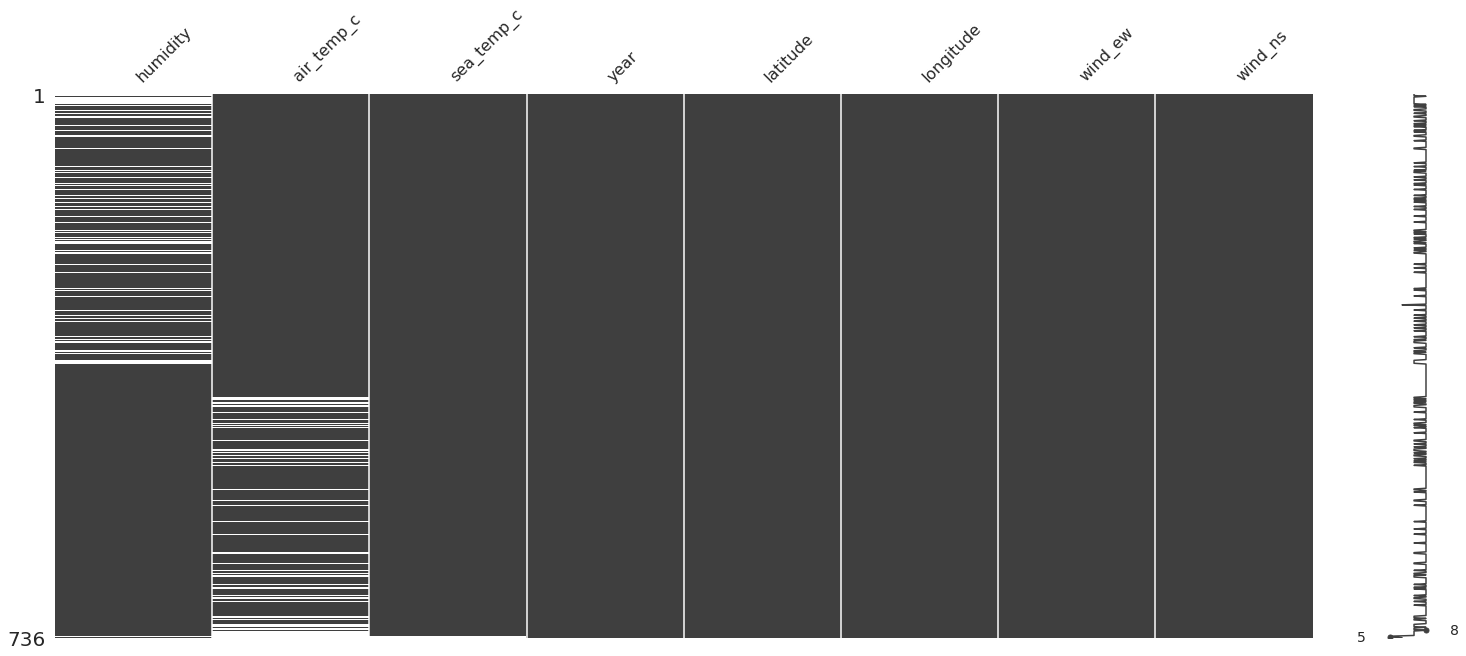

In [35]:
# ordena los valores segun una variable
(
    oceanbuoys_df
    .missing
    .sort_variables_by_missingness()
    .sort_values(by='sea_temp_c')
    .pipe(missingno.matrix)
)

Observamos que los valores faltantes de sea_temp_c dependen totalmente de air_temp_c por lo que son de tipo MAR

### Es de tipo MNAR?

<AxesSubplot:>

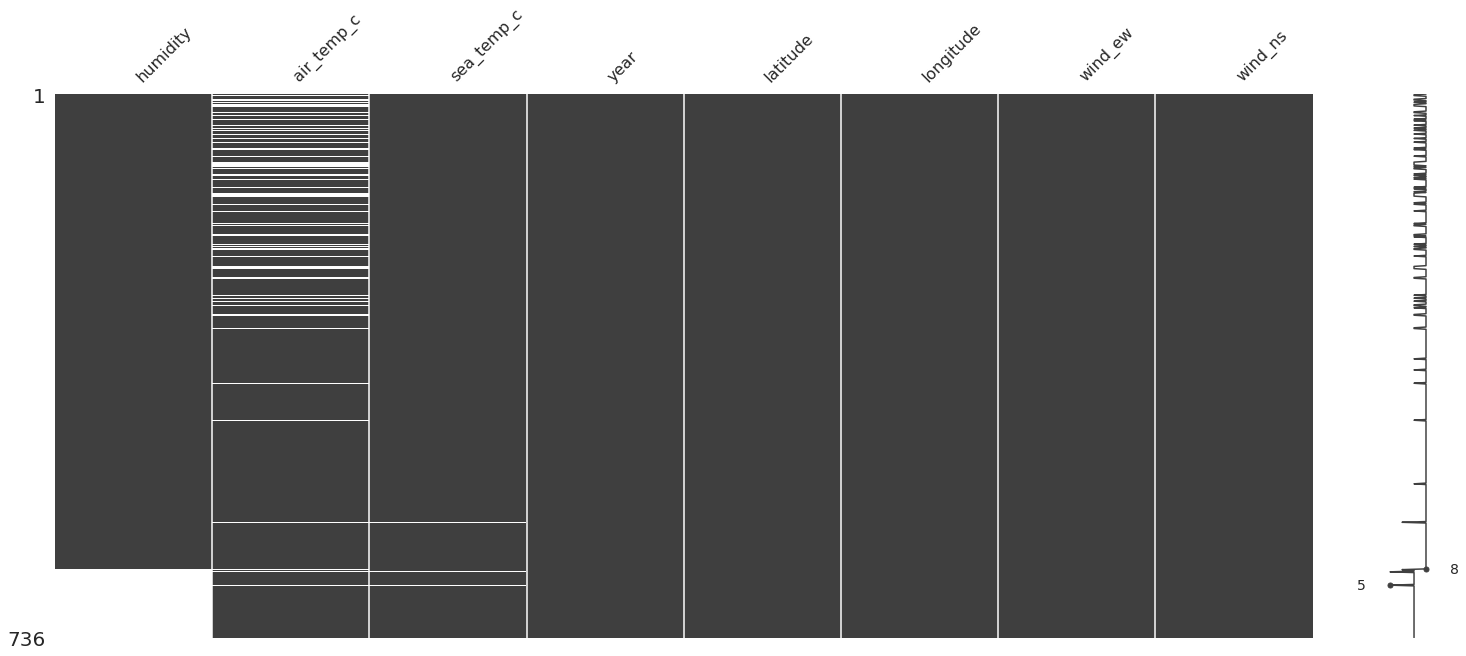

In [36]:
# ordena los valores segun una variable
(
    oceanbuoys_df
    .missing
    .sort_variables_by_missingness()
    .sort_values(by='humidity')
    .pipe(missingno.matrix)
)

La mayorias de valores faltantes de air_temp_c no dependen de humidity por lo que no son de tipo MNAR.

Para explicar el patron de los datos se debe conocer con mayor profundidad el contexto de los mismo ya que este analisis solo permite encontrar el mecanismo de generacion de los datos faltantes para cada variable y no de manera general.

## Comparacion de Estadisticos mediante la Matriz de Sombra

In [37]:
# construccion de la Matriz de sombra de forma manual

(
    oceanbuoys_df
    .isna()     # detecta los valores faltantes
    .replace({  # reemplaza los valores booleanos por valores informativos
        False:'Not missing',
        True:'Missing'
    })
    .add_suffix('_NA')  # agrega el sufijo NA sobre cada variable nueva  
    .pipe(
        lambda shadow_matrix: pd.concat(    # crea la matriz de sombra y la concatena con la matriz de valores
            [oceanbuoys_df, shadow_matrix],
            axis='columns'
        )
    )
)

,year,latitude,longitude,sea_temp_c,air_temp_c,humidity,wind_ew,wind_ns,year_NA,latitude_NA,longitude_NA,sea_temp_c_NA,air_temp_c_NA,humidity_NA,wind_ew_NA,wind_ns_NA
0,1997.0,0.0,-110.0,27.590000,27.150000,79.599998,-6.4,5.4,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
1,1997.0,0.0,-110.0,27.549999,27.020000,75.800003,-5.3,5.3,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
2,1997.0,0.0,-110.0,27.570000,27.000000,76.500000,-5.1,4.5,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
3,1997.0,0.0,-110.0,27.620001,26.930000,76.199997,-4.9,2.5,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
4,1997.0,0.0,-110.0,27.650000,26.840000,76.400002,-3.5,4.1,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,1993.0,-2.0,-110.0,24.780001,24.620001,90.800003,-4.4,1.7,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
732,1993.0,-2.0,-110.0,24.879999,24.500000,91.099998,-3.0,0.2,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
733,1993.0,-2.0,-110.0,25.120001,24.889999,89.699997,-4.0,1.1,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
734,1993.0,-2.0,-110.0,25.160000,24.930000,89.500000,-4.3,2.5,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing


In [38]:
# Construccion de la matriz de sombra mediante una funcion

(
    oceanbuoys_df
    .missing
    .bind_shadow_matrix(only_missing=True) # True para que aplique sobre las columnas con missing
)

,year,latitude,longitude,sea_temp_c,air_temp_c,humidity,wind_ew,wind_ns,sea_temp_c_NA,air_temp_c_NA,humidity_NA
0,1997.0,0.0,-110.0,27.590000,27.150000,79.599998,-6.4,5.4,Not Missing,Not Missing,Not Missing
1,1997.0,0.0,-110.0,27.549999,27.020000,75.800003,-5.3,5.3,Not Missing,Not Missing,Not Missing
2,1997.0,0.0,-110.0,27.570000,27.000000,76.500000,-5.1,4.5,Not Missing,Not Missing,Not Missing
3,1997.0,0.0,-110.0,27.620001,26.930000,76.199997,-4.9,2.5,Not Missing,Not Missing,Not Missing
4,1997.0,0.0,-110.0,27.650000,26.840000,76.400002,-3.5,4.1,Not Missing,Not Missing,Not Missing
...,...,...,...,...,...,...,...,...,...,...,...
731,1993.0,-2.0,-110.0,24.780001,24.620001,90.800003,-4.4,1.7,Not Missing,Not Missing,Not Missing
732,1993.0,-2.0,-110.0,24.879999,24.500000,91.099998,-3.0,0.2,Not Missing,Not Missing,Not Missing
733,1993.0,-2.0,-110.0,25.120001,24.889999,89.699997,-4.0,1.1,Not Missing,Not Missing,Not Missing
734,1993.0,-2.0,-110.0,25.160000,24.930000,89.500000,-4.3,2.5,Not Missing,Not Missing,Not Missing


### Exploracion de estadisticos mediante la Matriz de sombra

In [39]:
# Valores faltantes de la humedad en funcion de la temperatura del mar

print('Valores faltantes de la humedad en funcion de la temperatura del mar ')
(
    oceanbuoys_df
    .missing.bind_shadow_matrix(only_missing=True) # crea la matriz de sombra
    .groupby(['humidity_NA'])                      # agrupar por la ausencia de la humedad
    ['sea_temp_c']                                 # variable temperatura como referencia
    .describe()
    .reset_index()
)

Valores faltantes de la humedad en funcion de la temperatura del mar 


,humidity_NA,count,mean,std,min,25%,50%,75%,max
0,Missing,91.0,23.415934,1.137388,21.60,22.469999,23.370001,24.110000,26.379999
1,Not Missing,642.0,26.212087,2.385814,21.84,23.882499,27.455000,28.299999,30.170000


Aca podemos ver en la tabla que para los valores faltantes de la humedad en funcion de la temperatura del mar la media donde hay datos es de 23 y el valor maximo es de 26. Mientras que donde no hay datos la media es de 26 y el valor maximo de 30. La diferencia entre ambos valores es bastante notoria por lo que podemos concluir que estas variables estan relacionadas.

In [40]:
# valores faltantes de la humedad en funcion de la temperatura del aire

print('Valores faltantes de la humedad en funcion de la temperatura del aire ')
(
    oceanbuoys_df
    .missing.bind_shadow_matrix(only_missing=True) # crea la matriz de sombra
    .groupby(['humidity_NA'])                      # agrupar por la ausencia de la humedad
    ['air_temp_c']                                 # variable temperatura como referencia
    .describe()
    .reset_index()
)

Valores faltantes de la humedad en funcion de la temperatura del aire 


,humidity_NA,count,mean,std,min,25%,50%,75%,max
0,Missing,90.0,23.067667,0.934387,21.420000,22.260000,22.950001,23.700001,24.959999
1,Not Missing,565.0,25.341717,1.946489,22.059999,23.450001,25.780001,27.190001,28.500000


Al igual que en el caso anterior, como los valores tanto de la media como del valor maximo son cercanos, ambas variables tienen cierta relacion.

In [41]:
# valores faltantes de la temperatura del aire en funcion de la temperatura del mar

print('Valores faltantes de la temperatura del aire en funcion de la temperatura del mar ')
(
    oceanbuoys_df
    .missing.bind_shadow_matrix(only_missing=True) # crea la matriz de sombra
    .groupby(['air_temp_c_NA'])                      # agrupar por los missing de air_temp_c
    ['sea_temp_c']                                 # variable temperatura como referencia
    .describe()
    .reset_index()
)

Valores faltantes de la temperatura del aire en funcion de la temperatura del mar 


,air_temp_c_NA,count,mean,std,min,25%,50%,75%,max
0,Missing,78.0,28.412820,0.886468,24.15,27.765,28.385,28.9875,30.170000
1,Not Missing,655.0,25.561542,2.398097,21.60,23.420,24.740,28.0900,29.549999


En este caso, ambas variables tienen poca relacion

In [42]:
# valores faltantes de la humedad en funcion de la latitud

print('Valores faltantes de la humedad en funcion de la latitud ')
(
    oceanbuoys_df
    .missing.bind_shadow_matrix(only_missing=True) # crea la matriz de sombra
    .groupby(['humidity_NA'])                      # agrupar por los missing de humedad
    ['latitude']                                 # variable latitud como referencia
    .describe()
    .reset_index()
)

Valores faltantes de la humedad en funcion de la latitud 


,humidity_NA,count,mean,std,min,25%,50%,75%,max
0,Missing,93.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,Not Missing,643.0,-1.573872,1.679657,-5.0,-2.0,-2.0,0.0,0.0


## Visualizacion de Datos Faltantes en una variable mediante la Matriz de sombra

### Diagrama de caja

<AxesSubplot:xlabel='humidity_NA', ylabel='air_temp_c'>

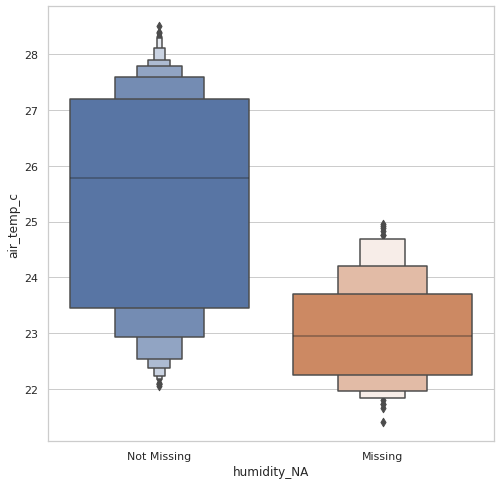

In [43]:
# comparando los missing de humidity con los de air_temp_c

(
    oceanbuoys_df
    .missing
    .bind_shadow_matrix(only_missing=True)
    .pipe(
        lambda df: (
            sns.boxenplot(
                data=df,
                x='humidity_NA',
                y='air_temp_c'
            )
        )
    )
)

De la grafica vemos que los missing de humedad indica una media cercana a 23 para la temperatura del aire. Mientras que los valores de humedad indica una media cercana a 26. Esto sugiere que la variable temperatura del aire si se ve afectada por los missing de humedad.

<AxesSubplot:xlabel='air_temp_c_NA', ylabel='sea_temp_c'>

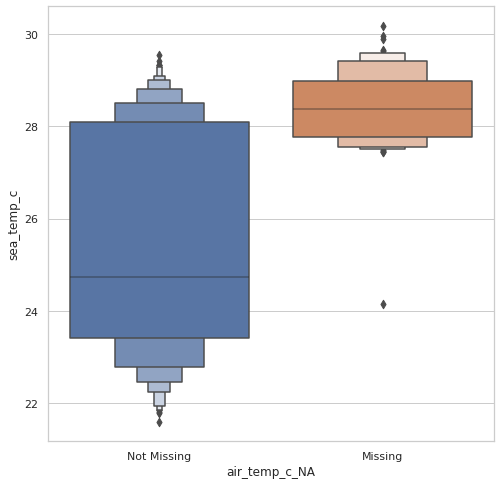

In [44]:
# comparando air_temp_c con sea_temp_c

(
    oceanbuoys_df
    .missing
    .bind_shadow_matrix(only_missing=True)
    .pipe(
        lambda df: (
            sns.boxenplot(
                data=df,
                x='air_temp_c_NA',
                y='sea_temp_c'
            )
        )
    )
)

De la grafica vemos que los missing de la temperatura del aire tienen una media superior a 28 para la temperatura del mar. Mientras que los los valores del aire indican una media cercana a 25. Esto indica que la variable temperatura del aire se ve afectada por la temperatura del mar o viceversa.

### Funcion de Densidad

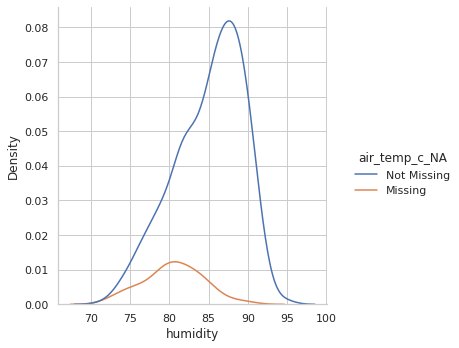

In [45]:
# comparando la variable humedad con temperatura del aire

(
    oceanbuoys_df
    .missing.bind_shadow_matrix(only_missing=True)
    .pipe(
        lambda df:(
            sns.displot(
                data=df,
                x='humidity',
                hue='air_temp_c_NA',
                kind='kde'
            )
        )
    )
)

La grafica nos muestra como los valores faltantes de la temperatura del aire sesgan a la derecha los datos de humedad. Esto reafirma la relacion entre ambas variables.

### Histogramas

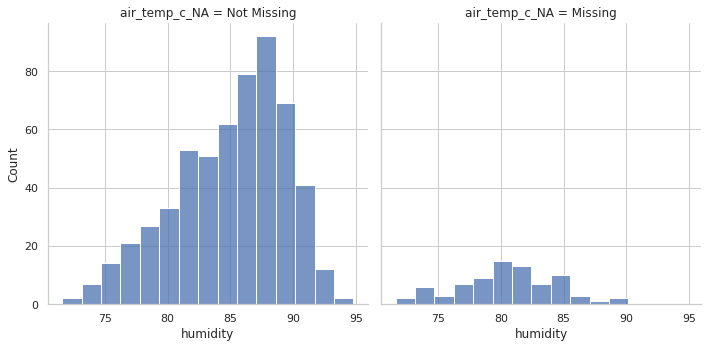

In [46]:
# comparando los missing de la variable Humedad con los valores de temperatura del aire

(
    oceanbuoys_df
    .missing.bind_shadow_matrix(only_missing=True)
    .pipe(
        lambda df:(
            sns.displot(
                data=df,
                x='humidity',
                col='air_temp_c_NA'
            )
        )
    )
)

Una vez mas, vemos el sesgo entre la media de temperatura del aire con datos faltantes y completos para la humedad. Esto indica que los missing de la temperatura afectan los valores de humedad. este tipo de grafica son dificiles de comparar cuando la cantidad de valores faltantes es muy pequena.

### Histogramas Independientes

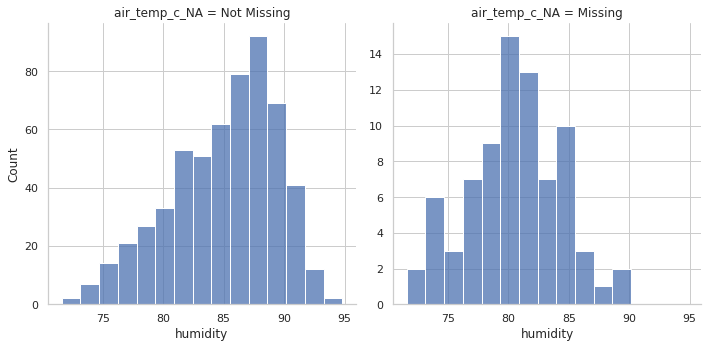

In [47]:
# eje de las Y independiente para cada grafica.
# comparando los missing de la variable Humedad con los valores de temperatura del aire
(
    oceanbuoys_df
    .missing.bind_shadow_matrix(only_missing=True)
    .pipe(
        lambda df:(
            sns.displot(
                data=df,
                x='humidity',
                col='air_temp_c_NA',
                facet_kws={
                    'sharey':False
                }
            )
        )
    )
)

Al modificar la escala del eje Y podemos visualizar mejor la tendencia de los valores faltantes de la variable analizada.

### Grilla de Histogramas 

Es util cuando se contrata los valores faltantes de dos dos variable sobre una tercera.

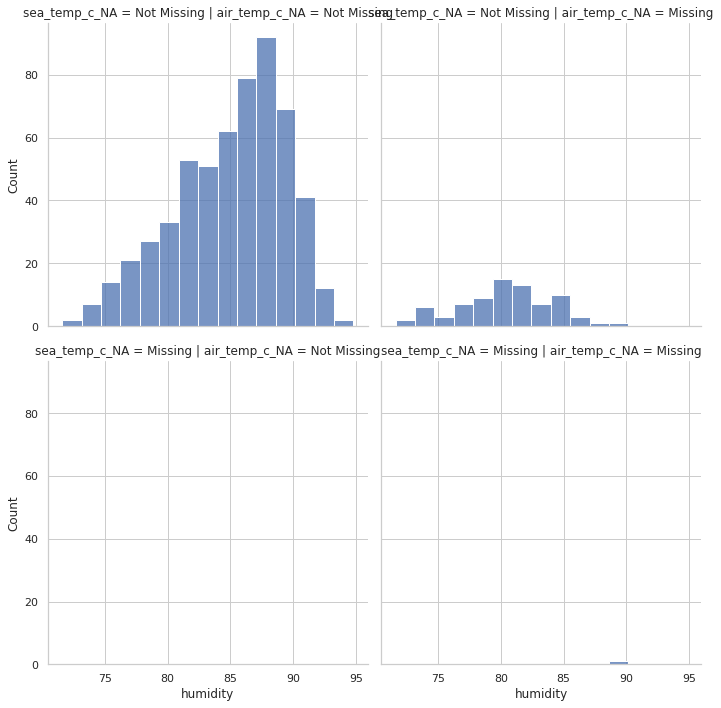

In [48]:
(
    oceanbuoys_df
    .missing.bind_shadow_matrix(only_missing=True)
    .pipe(
        lambda df:(
            sns.displot(
                data=df,
                x='humidity',
                col='air_temp_c_NA',
                row='sea_temp_c_NA'
            )
        )
    )
)

Vemos que no hay valores de humedad cuando existen valores de temperatura del aire y valores faltantes en la temperatura del mar. Hay una pequena porcion de valores de humedad con valor alrededor de 90 cuando no existen valores tanto de temperatura del mar como del aire. Tambien observamos la relacion que existe entre la humedad y la temperatura del aire al comparar los primeros histogramas.

## Visualizacion de Valores Faltantes en dos Variables

Permite visualizar y compara dos variables cuando ambas le faltan valores. Se utilizan los scatteplot. Para lograr una visualizacion efectiva, se debe agregar valores aleatorios a las variables con missing, esto lo hermos mediante una funcion de la clase missing.

### Scatterplot para dos Variables con Valores Faltantes 

In [49]:
# funcion que agrega valores aleatorios a las variables con missing

def column_fill_with_dummies(
    column: pd.Series,
    proportion_below: float=0.10, # proporcion de los datos en la grafica
    jitter: float=0.075,          # parametro que evita el asolapamiento de los puntos de la grafica
    seed: int=42                  # semilla para la aleatoriedad
    ) -> pd.Series:               # la funcion retorna una Serie

    # copiar las columnas del DataFrame
    column = column.copy(deep=True)

    # extraer los valores de las variables 
    missing_mask = column.isna()                # matriz de booleanos
    number_missing_values = missing_mask.sum()  # conteo de valores faltantes
    column_range = column.max() - column.min()  # rango de las variables

    # Datos de turno
    column_shift = column.min() - column.min()*proportion_below

    # Ruido alrededor de los puntos
    np.random.seed(seed)
    column_jitter = (np.random.rand(number_missing_values) - 2) * column_range * jitter

    # guarda los nuevos datos aleatorios
    column[missing_mask] = column_shift + column_jitter

    return column

<AxesSubplot:xlabel='humidity', ylabel='air_temp_c'>

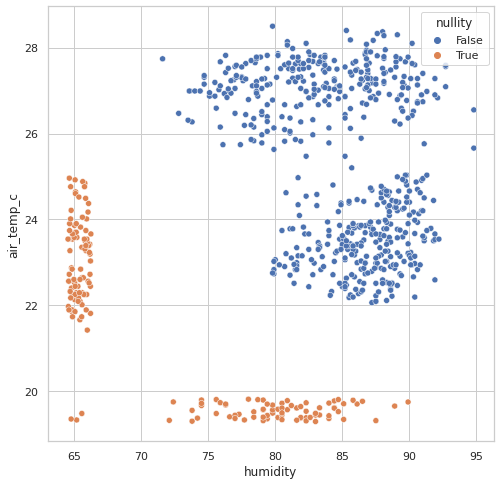

In [50]:
# analisis para la variable humedad y temperatura del aire

(
    oceanbuoys_df
    .select_dtypes(
        exclude='category' # se excluyen las variables categoricas
    )
    .pipe(  # selecciona solo variables con valores faltantes
        lambda df: df[df.columns[df.isna().any()]]
    )   # matriz de sombra con valores True para valores completos y False para missing
    .missing.bind_shadow_matrix(true_string=True, false_string=False)
    .apply(
        lambda column: column if '_NA' in column.name else column_fill_with_dummies(column, proportion_below=0.05, jitter=0.075)
    )
    .assign(
        nullity = lambda df: df.humidity_NA | df.air_temp_c_NA
    )
    .pipe(
        lambda df:(
            sns.scatterplot(
                data=df,
                x='humidity',
                y='air_temp_c',
                hue='nullity'
            )
        )
    )
)

Los puntos azules indican que existen observaciones para ambas variables. Los puntos naranjas indican que existe observacion para una variable y no para la otra. Vemos que existen un mayor numero de observaciones que tienen temperatura del aire pero no humedad y estan agrupados entre 22 y 25 

<AxesSubplot:xlabel='sea_temp_c', ylabel='air_temp_c'>

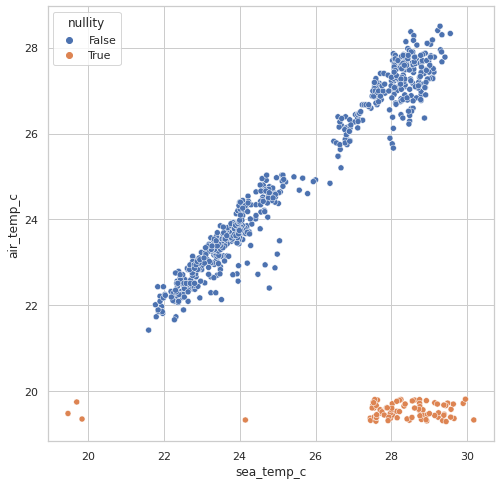

In [51]:
# analisis para la variable temperatura del mar y temperatura del aire

(
    oceanbuoys_df
    .select_dtypes(
        exclude='category' # se excluyen las variables categoricas
    )
    .pipe(  # selecciona solo variables con valores faltantes
        lambda df: df[df.columns[df.isna().any()]]
    )   # matriz de sombra con valores True para valores completos y False para missing
    .missing.bind_shadow_matrix(true_string=True, false_string=False)
    .apply(
        lambda column: column if '_NA' in column.name else column_fill_with_dummies(column, proportion_below=0.05, jitter=0.075)
    )
    .assign(
        nullity = lambda df: df.sea_temp_c_NA | df.air_temp_c_NA
    )
    .pipe(
        lambda df:(
            sns.scatterplot(
                data=df,
                x='sea_temp_c',
                y='air_temp_c',
                hue='nullity'
            )
        )
    )
)

En este grafico podemos ver claramente que todas las observaciones con valores de temperatura del aire tienen su respectivo valor de temperatura del mar. Sin embargo, hay observaciones que a pesar de tener sus valores de temperatura del mar, no tienen sus valores de temperatura del aire. Estos ultimos estan agrupados entre 27 y 30. Concluimos que los valores de temperatura del aire dependen de la existencia de la temperatura del mar. 

## Correlacion de Nulidad

Nos permite encontrar relaciones entre las variables en funcion de su nulidad. PAra ello, tenemos los heatmaps y dendogramas

### Heatmaps

<AxesSubplot:>

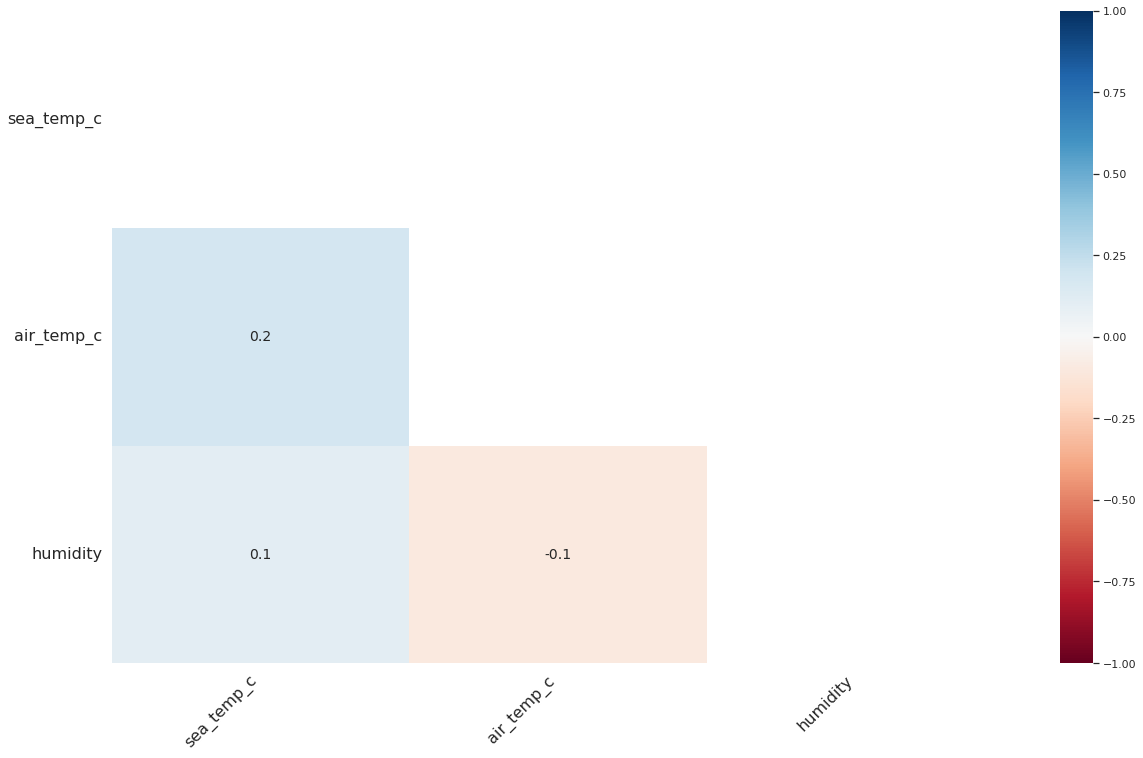

In [52]:
missingno.heatmap(df=oceanbuoys_df)

El heatmaps de las variables contenidas en el dataframe indica:

- Hay una correlacion positiva mayor entre las temperaturas, es decir, la presencia de un missing en la temperatura del aire esta correlacionado con un missing en la temperatura del mar.

- Tambien vemos que hay una pequena correlacion negativa entre la humedad y la temperatura del aire, es decir, la presencia de un missing en la humedad esta correlacionado con un valor completo de temperatura del aire.

- No hay correlacion entre la humedad y las temperaturas.

### Dendograma

<AxesSubplot:>

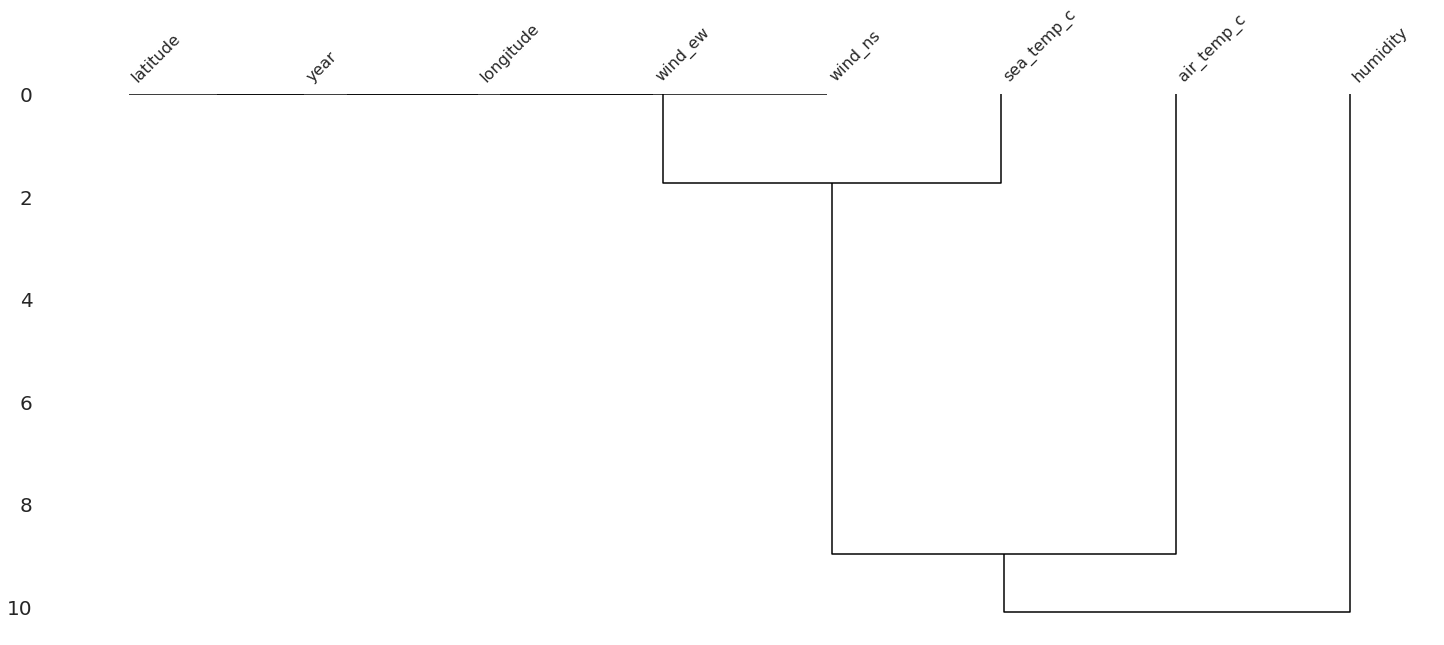

In [53]:
missingno.dendrogram(df=oceanbuoys_df)

El dendograma indica que las variables latitud, year, longitud y viento este-oeste estan muy correlacionadas por sus valores completos. Por otro lado vemos que las temperaturas estan correlacionadas por sus valores faltantes y la que mayor correlacion presenta son la humedad y la temperatura del aire.

## Eliminacion de Valores Faltantes

In [55]:
# calculo de la media para la temperatura del aire
# Para este caso, ya viene integrado a pandas. Ignora las observaciones con datos faltantes.
(
    oceanbuoys_df
    .air_temp_c
    .mean()
)

25.02925191120608

In [56]:
# numero de observaciones vs numero de valores completos para air_temp_c
oceanbuoys_df.air_temp_c.size, oceanbuoys_df.air_temp_c.count()

(736, 655)

Existen 736 registros de los cuales 655 estan completos

In [57]:
# media de air_temp_c considerando los missing
oceanbuoys_df.air_temp_c.mean(skipna=False)

nan

Al considerar los missing el programa no lo puede calcular y arroja nan

### Eliminacion por Lista para una variable

In [58]:
# elimina las observaciones completas que contengan al menos un valor faltante
(
    oceanbuoys_df
    .dropna(
        subset=['air_temp_c'],
        how='any'
    )
).shape

(655, 8)

Elimino 81 observaciones que contenian missing para la variable air_temp_c

### Eliminacion por Lista para dos variables

In [61]:
# elimina las observaciones que contengan valores faltantes en cualquiera de las dos variables
(
    oceanbuoys_df
    .dropna(
        subset=['humidity', 'sea_temp_c'],
        how='any'
    )
).shape

(642, 8)

Vemos que para este caso se elimina 94 observaciones las cuales contienen miising en cualquiera de las dos variables

### Eliminacion por Listas donde ambas variables contengan datos faltantes

In [62]:
# elimina las observaciones con missing en ambas variables simultaneamente
(
    oceanbuoys_df
    .dropna(
        subset=['humidity','sea_temp_c'],
        how='all'
    )
).shape

(734, 8)

Se han eliminado dos observaciones para este caso

### Visualizacion de los datos tras la eliminacion de valores faltantes

<AxesSubplot:>

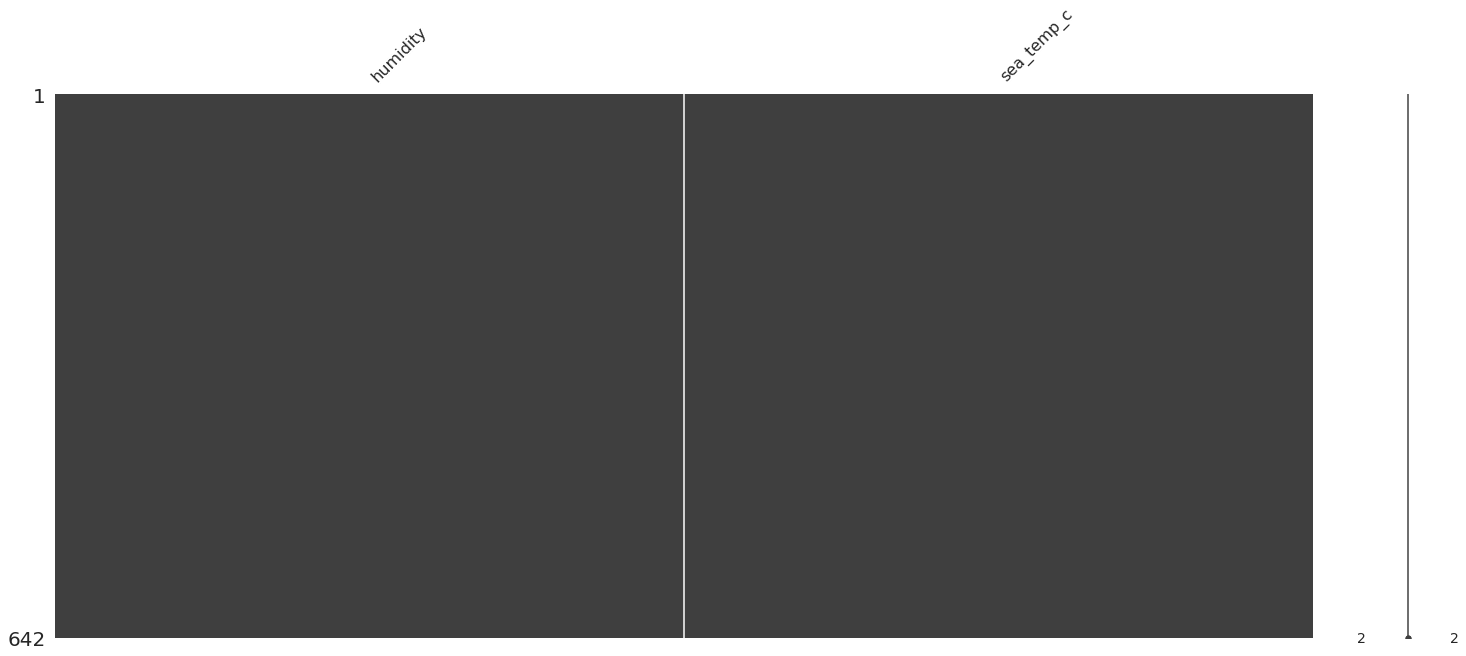

In [63]:
# con any
(
    oceanbuoys_df
    .dropna(
        subset=['humidity', 'sea_temp_c'],
        how='any'
    )
    .select_columns(['humidity', 'sea_temp_c'])
    .pipe(missingno.matrix)
)

En ambas variables los datos quedan limpios de datos faltantes

<AxesSubplot:>

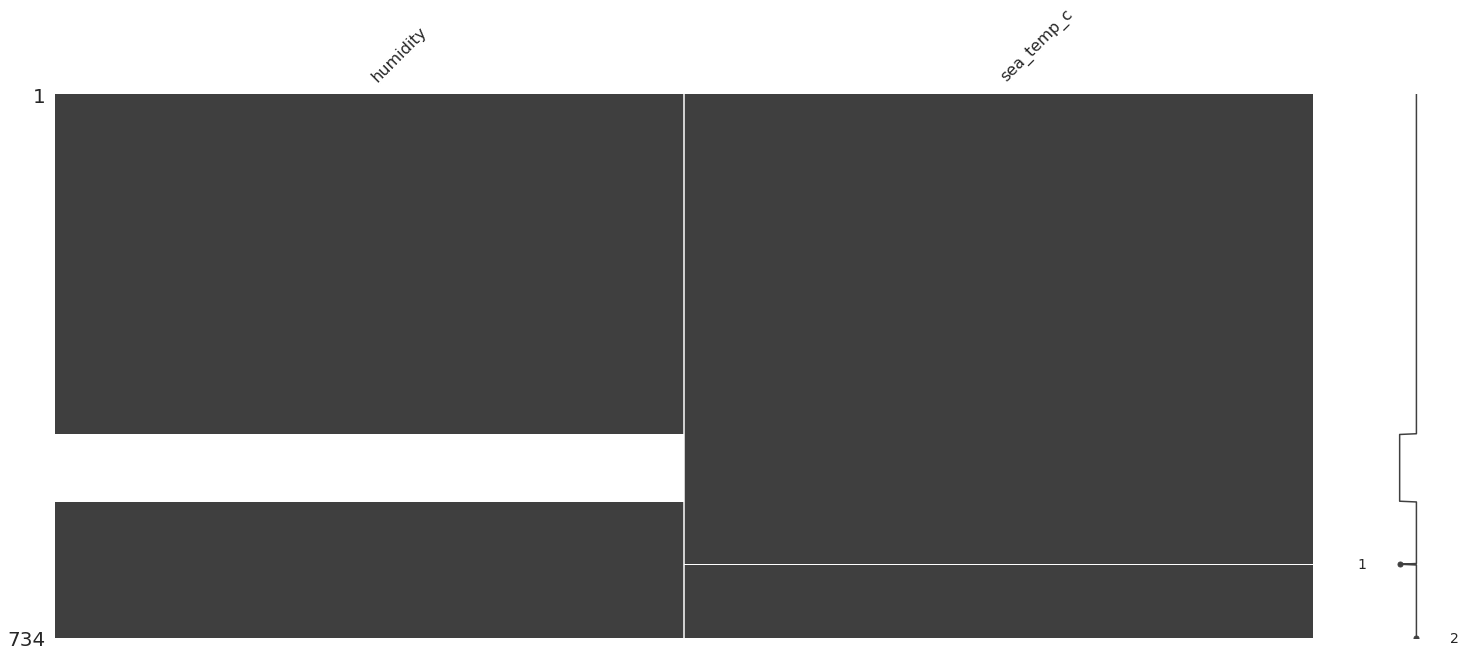

In [64]:
# con all
(
    oceanbuoys_df
    .dropna(
        subset=['humidity', 'sea_temp_c'],
        how='all'
    )
    .select_columns(['humidity', 'sea_temp_c'])
    .pipe(missingno.matrix)
)

Para este caso, aunque quedan registro en ambas observaciones con valores faltantes, se han eliminado aquellos con valores faltantes en ambas variables